--- Schritt 2: LLM-reparierte Daten laden (FF3 Basis) ---
Datensatz geladen: ergebnisse/2.2_rfd_repaired_llm.csv (1326 Zeilen)

--- Schritt 3: Typ-Konvertierung, NaN-Handhabung & Skalierung ---
STATUS: Erzwinge Konvertierung zu Float...
STATUS: Führe Standardisierung (Skalierung) der Zieldaten durch...
STATUS: Daten erfolgreich skaliert (Z-Score).

--- Schritt 4: LOF-Methode anwenden (Erweiterte Zielspalten) ---
Starte LOF-Analyse (fit_predict) auf skalierten Daten...
LOF-Analyse abgeschlossen.
ERGEBNIS (LOF): 108 Zeilen wurden als Ausreißer (Label -1) identifiziert.

--- Schritt 5: Visualisierung der LOF-Ergebnisse (Streudiagramme) ---
Erstelle Streudiagramme zur Visualisierung der LOF-Ergebnisse...


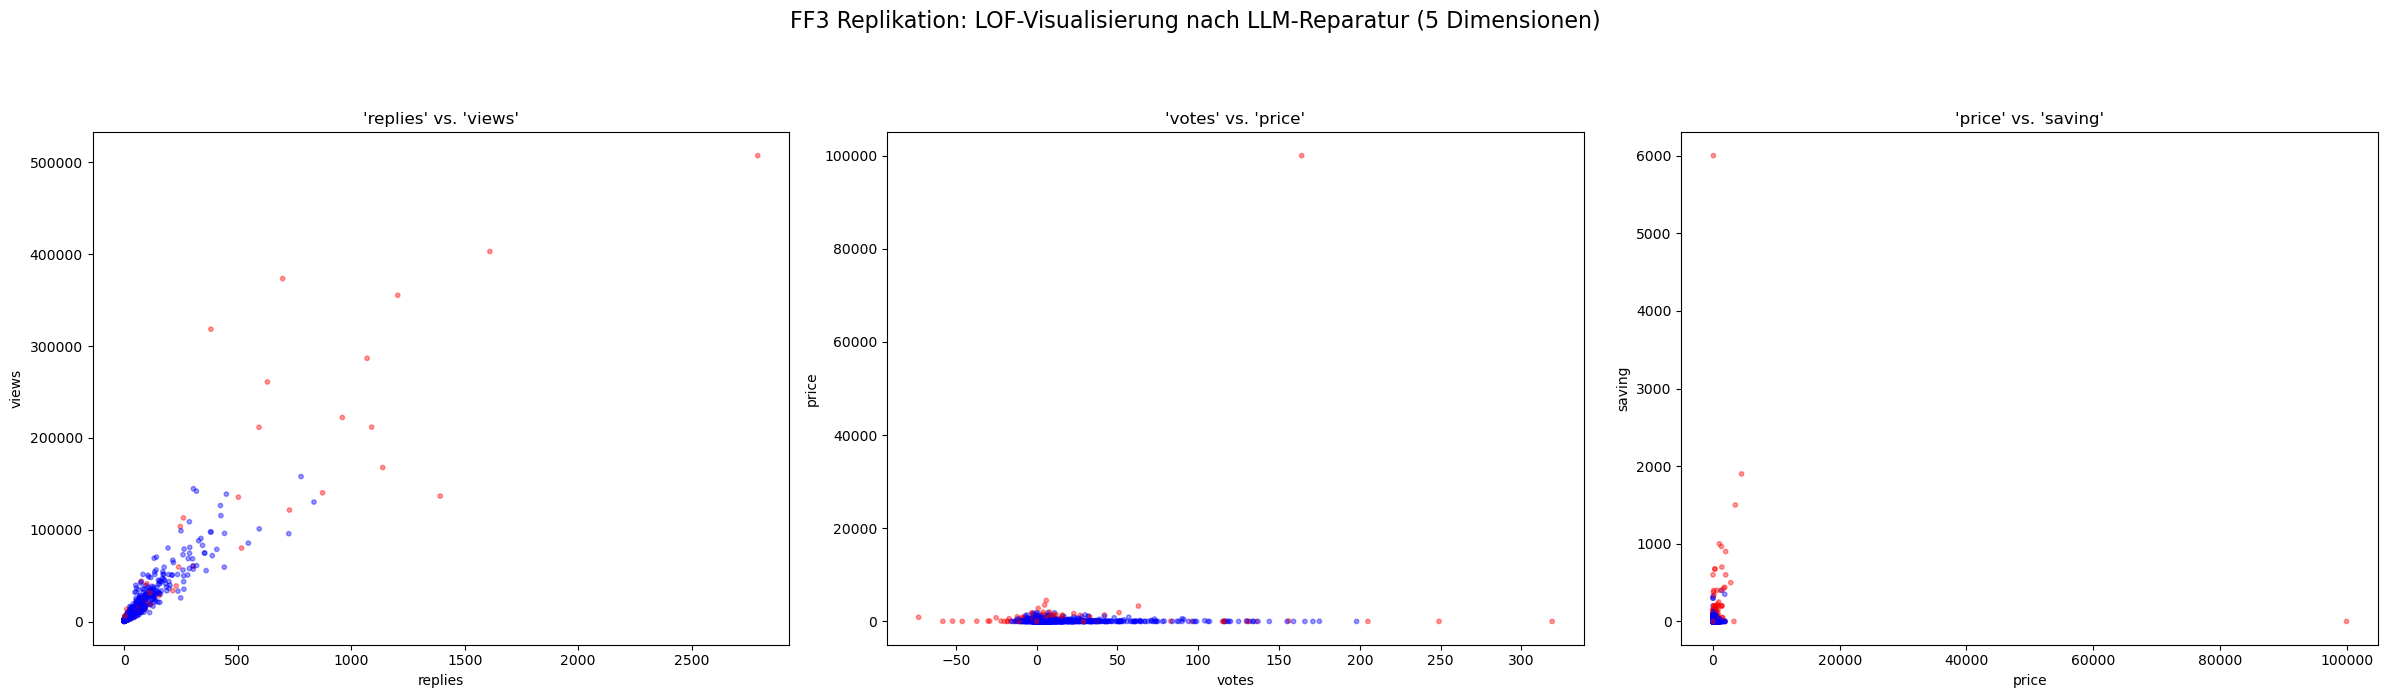


Visuelle Bestätigung: Die Plots zeigen nun die mehrdimensionale Ausreißer-Erkennung, die durch die Formatbereinigung (FF2) auf den Spalten 'price' und 'saving' ermöglicht wurde.

--- Schritt 6: Ergebnisse speichern und Zusammenfassung ---
Dieses Skript (10) ist nun abgeschlossen.

Ergebnisse (Ausreißer-Indizes) wurden in 'ergebnisse/3.2_lof_ausreisser_indizes.csv' gespeichert.

--- ZUSAMMENFASSUNG EXPERIMENT 3.2 (LOF Replikation - LLM Basis) ---
Methode:           Klassisches ML: LOF (dichte-basiert)
Basisdaten:        ergebnisse/2.2_rfd_repaired_llm.csv
Zielspalten:       ['replies', 'views', 'votes', 'price', 'saving'] (als 5D-Merkmalsraum)
ERGEBNIS (COUNT):  108 einzigartige Ausreißerzeilen identifiziert.
Das Ergebnis dient dem Vergleich der LOF-Leistung auf RAW vs. LLM-Daten.


In [2]:
################################################################################
# MASTERARBEIT - SKRIPT 10:
# EXPERIMENT 3.2 (Forschungsfrage 3) - LOF REPLIKATION (LLM-Basis)
################################################################################
#
# ZWECK DIESES SKRIPTS (Methodik gemäß Forschungsfrage 3):
#
# 1. (Basis): Misst den Einfluss der vorherigen LLM-Inkonsistenzbehebung (FF2.2) 
#    auf die Ausreißererkennung.
#
# 2. (Datenbasis): Lädt den vom LLM reparierten Datensatz (2.2_rfd_repaired_llm.csv).
#
# 3. (Zielspalten): Erweitert die Analyse von FF1 ('replies', 'views', 'votes') 
#    um die nun numerisch gewordenen Spalten ('price', 'saving').
#
# 4. (Voraussetzung): Führt die notwendige Zwangskonvertierung (Type Casting) 
#    und NaN-Behandlung durch, da LOF nur mit numerischen Daten arbeitet.
#
# 5. (Speichern): Speichert die identifizierten Ausreißer-Indizes für die 
#    abschließende Evaluation (Skript 12).
#
################################################################################

# Schritt 1: Notwendige Bibliotheken importieren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler # Wird für ML-Methoden benötigt

# --- GLOBALE KONSTANTEN FÜR DIESES EXPERIMENT ---
# Wir replizieren die FF1-Methode, ändern aber die Basis und den Output-Pfad.
DATEIPFAD_LLM_REPAIRED = 'ergebnisse/2.2_rfd_repaired_llm.csv'
DATEIPFAD_OUTPUT = 'ergebnisse/3.2_lof_ausreisser_indizes.csv'

# Zielspalten: FF1-Spalten + die durch FF2 reparierten Spalten
zielspalten = ['replies', 'views', 'votes', 'price', 'saving']

#
################################################################################

# SCHRITT 2: Laden der LLM-reparierten Daten (FF2.2 Ergebnis)
print("--- Schritt 2: LLM-reparierte Daten laden (FF3 Basis) ---")

try:
    # LLM-Daten laden (Index wird mitgeladen)
    df_llm = pd.read_csv(DATEIPFAD_LLM_REPAIRED, index_col='original_index')
    df_llm = df_llm.reset_index(drop=True)
    print(f"Datensatz geladen: {DATEIPFAD_LLM_REPAIRED} ({df_llm.shape[0]} Zeilen)")
except FileNotFoundError:
    print(f"FEHLER: LLM-Ergebnisdatei '{DATEIPFAD_LLM_REPAIRED}' nicht gefunden.")
    sys.exit("Skript gestoppt.")

#
################################################################################

# --- SCHRITT 3: Datentyp-Konvertierung und Skalierung (Voraussetzung für LOF) ---
print("\n--- Schritt 3: Typ-Konvertierung, NaN-Handhabung & Skalierung ---")

# 1. Numerische Konvertierung erzwingen (price, saving)
try:
    print("STATUS: Erzwinge Konvertierung zu Float...")
    numerische_spalten_repariert = ['price', 'saving']
    
    for col in numerische_spalten_repariert:
        # Konvertierung zu Float erzwingen (behebt die Pandas-Object-Lesefehler)
        df_llm[col] = pd.to_numeric(df_llm[col], errors='coerce')
    
    # NaN-Handhabung: LOF kann keine NaN verarbeiten. Wir füllen NaNs mit 0.
    df_llm[numerische_spalten_repariert] = df_llm[numerische_spalten_repariert].fillna(0)
    
    # 2. Skalierung (Zwingend für LOF)
    # LOF basiert auf Distanzmessen. Spalten mit großen Skalen (views)
    # würden kleine Spalten (price/replies) dominieren. Standardisierung 
    # (Z-Score) ist notwendig.
    
    print("STATUS: Führe Standardisierung (Skalierung) der Zieldaten durch...")
    
    # Daten für die Skalierung extrahieren
    X_data = df_llm[zielspalten].values 
    
    # StandardScaler (Z-Score-Normalisierung)
    scaler = StandardScaler()
    X_skaliert = scaler.fit_transform(X_data)
    
    print("STATUS: Daten erfolgreich skaliert (Z-Score).")
    
except Exception as e:
    print(f"FEHLER bei der Skalierung/Typkonvertierung: {e}")
    sys.exit("Skript gestoppt.")

#
################################################################################

# SCHRITT 4: Definition und Anwendung der LOF-Methode (Replikation von FF1)
print("\n--- Schritt 4: LOF-Methode anwenden (Erweiterte Zielspalten) ---")

# LOF-Parameter bleiben identisch zu Skript 03 (FF1) für faire Replikation
lof_modell = LocalOutlierFactor(n_neighbors=20, contamination='auto')

print("Starte LOF-Analyse (fit_predict) auf skalierten Daten...")

# Training und Vorhersage auf den skalierten Daten
y_vorhersage = lof_modell.fit_predict(X_skaliert)
print("LOF-Analyse abgeschlossen.")

# 4. Extrahieren der als Ausreißer identifizierten Indizes
ausreisser_indizes_lof = df_llm.index[y_vorhersage == -1].tolist()

print(f"ERGEBNIS (LOF): {len(ausreisser_indizes_lof)} Zeilen wurden als \
Ausreißer (Label -1) identifiziert.")
print("=" * 70)

#
################################################################################

# SCHRITT 5: Visualisierung der LOF-Ergebnisse (Streudiagramme)
print("\n--- Schritt 5: Visualisierung der LOF-Ergebnisse (Streudiagramme) ---")

# Da wir nun 5 Dimensionen haben, wählen wir die relevantesten 2D-Kombinationen 
# für die Visualisierung der Ausreißer.
print("Erstelle Streudiagramme zur Visualisierung der LOF-Ergebnisse...")

# Visualisierung der wichtigsten Paare (replies/views, votes/price)
farben = np.where(y_vorhersage == 1, 'blue', 'red')
plot_kombinationen = [
    ('replies', 'views'),
    ('votes', 'price'),
    ('price', 'saving') # Neue, durch FF2 ermöglichte Korrelation
]

fig, axes = plt.subplots(nrows=1, ncols=len(plot_kombinationen), figsize=(24, 7))

fig.suptitle('FF3 Replikation: LOF-Visualisierung nach LLM-Reparatur (5 Dimensionen)', 
             fontsize=16, y=1.02)

for i, (spalte_x, spalte_y) in enumerate(plot_kombinationen):
    ax = axes[i]
    
    ax.scatter(
        df_llm[spalte_x], 
        df_llm[spalte_y], 
        c=farben,       
        s=10,           
        alpha=0.4       
    )
    
    ax.set_title(f"'{spalte_x}' vs. '{spalte_y}'")
    ax.set_xlabel(spalte_x)
    ax.set_ylabel(spalte_y)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nVisuelle Bestätigung: Die Plots zeigen nun die mehrdimensionale Ausreißer-Erkennung, \
die durch die Formatbereinigung (FF2) auf den Spalten 'price' und 'saving' ermöglicht wurde.")
print("=" * 70)

#
################################################################################

# SCHRITT 6: Ergebnisse speichern und Zusammenfassung
print("\n--- Schritt 6: Ergebnisse speichern und Zusammenfassung ---")
print("Dieses Skript (10) ist nun abgeschlossen.")

os.makedirs('ergebnisse', exist_ok=True)

# 1. Definieren des Dateipfads für die Ergebnisse (FF3 LLM Basis)
ergebnis_dateipfad = DATEIPFAD_OUTPUT

# 2. Umwandeln der Index-Liste in eine sortierte Liste
ausreisser_liste_sortiert = sorted(ausreisser_indizes_lof)

# 3. Erstellen und Speichern des DataFrames
df_ergebnisse_lof = pd.DataFrame(ausreisser_liste_sortiert, columns=['Ausreisser_Index'])
df_ergebnisse_lof.to_csv(ergebnis_dateipfad, index=False)

print(f"\nErgebnisse (Ausreißer-Indizes) wurden in '{ergebnis_dateipfad}' gespeichert.")

# --- ZUSAMMENFASSUNG (Für das Protokoll/die Masterarbeit) ---
print("\n--- ZUSAMMENFASSUNG EXPERIMENT 3.2 (LOF Replikation - LLM Basis) ---")
print(f"Methode:           Klassisches ML: LOF (dichte-basiert)")
print(f"Basisdaten:        {DATEIPFAD_LLM_REPAIRED}")
print(f"Zielspalten:       {zielspalten} (als 5D-Merkmalsraum)")
print(f"ERGEBNIS (COUNT):  {len(df_ergebnisse_lof)} einzigartige Ausreißerzeilen identifiziert.")
print("=" * 70)
print(f"Das Ergebnis dient dem Vergleich der LOF-Leistung auf RAW vs. LLM-Daten.")
print("=" * 70)
